# 5장 모델 평가와 성능 향상

지금 까지 지도 학습과 비지도 학습 이론을 다루면서 다양한 머신러닝 알고리즘을 살펴봤다. 이제 모델 평가와 매개변수 선택에 대해 자세히 배워보자.

비지도 학습 모델을 평가하고 선택하는 일은 매우 정성적인 작업이므로 여기서는 지도 학습인 회귀와 분류에 집중할 것이다.

우리는 지도 학습 모델을 평가하기 위해 train_test_split 함수를 사용하여 데이터셋을 훈련 세트와 테스트 세트로 나눴다. 그리고 모델을 만들기 위해 훈련 세트에 fit 메서드를 적용했고, 모델을 평가하기 위해 테스트 세트에 score 메서드를 사용했다. 분류에서 score 메서드는 정확히 분류된 샘플의 비율을 계산하는 역할을 한다. 다음은 이 과정을 담은 예제이다.

In [2]:
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split as tts

# 인위적인 데이터셋을 만든다.
X, y = make_blobs(random_state=0)
# 데이터와 타깃 레이블을 훈련 세트와 테스트 세트로 나눈다.
X_train, X_test, y_train, y_test = tts(X,y,random_state=0)
# 모델 객체를 만들고 훈련 세트로 학습시킨다.
logreg = LogisticRegression().fit(X_train, y_train)
# 모델을 테스트 세트로 평가한다.
print("테스트 세트 점수: {:.3f}".format(logreg.score(X_test, y_test)))

테스트 세트 점수: 0.880


C:\Users\NT500R\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\NT500R\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


데이터를 훈련 세트와 테스트 세트로 나누는 이유는 지금까지 본 적 없는 새로운 데이터에 모델이 얼마나 잘 일반화되는지 측정하기 위해서이다. 모델이 훈련 세트에 잘 맞는 것보다, 학습 과정에 없던 데이터에 대해 예측을 얼마나 잘 하느냐가 중요하다.

이번 장에서는 두 가지 관점에서 이 평가 방법을 확장해보자. 먼저 안정적인 일반화 성능 측정 방법인 교차 검증을 소개하고, score 메서드가 제공하는 R^2값 이외에 분류와 회귀 성능을 측정하는 다른 방법을 알아보자.

또한 가장 좋은 일반화 성능을 얻기 위해서 지도 학습 모델의 매개변수를 조정하는 데 유용한 그리드 서치에 관해서도 해보자.

## 5.1 교차 검증

**교차 검증**(cross-validation)은 일반화 성능을 재기 위해 훈련 세트와 테스트 세트로 한 번 나누는 것보다 더 안정적이고 뛰어난 통계적 평가 방법이다. 교차 검증에서는 데이터를 여러 번 반복해서 나누고 여러 모델을 학습한다. 가장 널리 사용되는 교차 검증 방법은 **k-겹 교차 검증**(k-fold cross- validation)으로 k는 특성 숫자인데 보통 5 또는 10을 사용한다. 5-겹 교차 검증을 하려면 데이터를 먼저 **폴드**라고 하는 거의 비슷한 크기의 '부분 집합' 다섯 개로 나눈다. 다음 일련의 모델들을 만든다. 첫 번째 모델은 첫 번째 폴드를 테스트 세트로 사용하고 나머지(2에서 5까지) 폴드를 훈련 세트로 사용하여 학습한다. 즉 이 모델은 폴드 2~5까지의 데이터를 사용해 만들어지고 폴드 1을 사용해 정확도를 평가한다. 그다음 두 번째 모델은 폴드 2를 테스트 세트로 사용하고 폴드 1, 3, 4, 5의 데이터를 훈련 데이터로 사용한다. 이런 방법으로 폴드 3, 4, 5를 테스트 세트로 사용해 반복한다. 이렇게 데이터를 훈련 세트와 테스트 세트로 나누는 다섯 번의 분할마다 정확도를 측정하여, 결국 다섯 개의 정확도 값을 얻게 된다.

In [4]:
import sys
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as plp
import numpy as np
import scipy as sp
import IPython
import sklearn
import mglearn
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
#한글 폰트사용
plp.rcParams["font.family"] = "Malgun Gothic"
plp.rcParams["font.size"] = 12
plp.rcParams["figure.figsize"] = (14,4)

#마이너스 깨짐 해결
mpl.rcParams["axes.unicode_minus"] = False

from sklearn.model_selection import train_test_split as tts

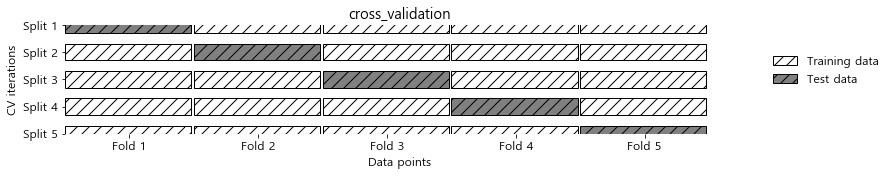

In [5]:
mglearn.plots.plot_cross_validation()

### 5.1.1 scikit-learn의 교차 검증

scikit-learn에서 교차 검증은 model_selection 모듈의 cross_val_score 함수로 구현되어있다. cross_val_score 함수의 매개변수는 평가하려는 모델과 훈련 데이터, 타깃 레이블이다. iris 데이터셋에 적용한 LogisticRegression을 평가해보자.

In [6]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

iris = load_iris()
logreg = LogisticRegression()
scores = cross_val_score(logreg, iris.data, iris.target)
print("교차 검증 점수:", scores)

교차 검증 점수: [0.96078431 0.92156863 0.95833333]


C:\Users\NT500R\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\NT500R\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\NT500R\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\NT500R\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\NT500R\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWa

여기에서는 cross_val_score가 3-겹 교차 검증을 수행했기 때문에 3개의 점수가 반환되었다. 폴드의 수는 cv 매개변수를 사용해서 바꿀 수 있다.

In [7]:
scores = cross_val_score(logreg, iris.data, iris.target, cv=5)
print("교차 검증 점수:",scores)

교차 검증 점수: [1.         0.96666667 0.93333333 0.9        1.        ]


C:\Users\NT500R\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\NT500R\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\NT500R\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\NT500R\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\NT500R\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Defau

보통 교차 검증의 정확도를 간단하게 나타내려면 평균을 사용한다.

In [8]:
print("교차 검증 평균 점수: {:.2f}".format(scores.mean()))

교차 검증 평균 점수: 0.96


교차 검증 평균값으로 우리는 이 모델의 정확도가 대략 96%일 것으로 기대할 수 있다. 5-겹 교차 검증이 만든 다섯 개의 값을 모두 보면 100%에서 90%까지 폴드에 따라 비교적 차이가 크다. 이는 모델이 훈련에 사용한 폴드에 매우 의존적이거나 데이터셋이 작기 때문일 수 있다. 교차 검증에 cross_validate 함수를 사용할 수도 있다. 이 함수는 cross_val_score 함수와 인터페이스가 비슷하지만 분할마다 훈련과 테스트에 걸린 시간을 담은 딕셔너리를 반환한다.

In [9]:
from sklearn.model_selection import cross_validate
res = cross_validate(logreg, iris.data, iris.target, cv=5, return_train_score=True)
display(res)

C:\Users\NT500R\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\NT500R\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\NT500R\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\NT500R\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\NT500R\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Defau

{'fit_time': array([0.0019927 , 0.00199628, 0.00199413, 0.00099754, 0.00099754]),
 'score_time': array([0.        , 0.00099778, 0.        , 0.        , 0.00099874]),
 'test_score': array([1.        , 0.96666667, 0.93333333, 0.9       , 1.        ]),
 'train_score': array([0.95      , 0.96666667, 0.96666667, 0.975     , 0.95833333])}

In [10]:
res_df = pd.DataFrame(res)
display(res_df)
print("평균 시간과 점수:\n", res_df.mean())

,fit_time,score_time,test_score,train_score
0,0.001993,0.000000,1.000000,0.950000
1,0.001996,0.000998,0.966667,0.966667
2,0.001994,0.000000,0.933333,0.966667
3,0.000998,0.000000,0.900000,0.975000
4,0.000998,0.000999,1.000000,0.958333


평균 시간과 점수:
 fit_time       0.001596
score_time     0.000399
test_score     0.960000
train_score    0.963333
dtype: float64


### 5.1.2 교차 검증의 장점

데이터를 훈련 세트와 테스트 세트로 한 번 나누는 것보다 교차 검증을 사용하면 몇가지 장점이 있다. 먼저 train_test_split은 데이터를 무작위로 나눈다. 데이터를 무작위로 나눌 때 운 좋게 훈련 세트에는 분류하기 어려운 샘플만 담기게 되었다고 생각해보자. 이 경우 테스트 세트에는 분류하기 쉬운 샘플만 들어 있어서 테스트 세트의 정확도는 비현실적으로 높게 나올 것이다. 반대로 운 나쁘게 분류하기 어려운 샘플들이 모두 테스트 세트에 들어간다면 정확도가 아주 낮게 나올 것이다. 그러나 교차 검증을 사용하면 테스트 세트에 각 샘플이 정확하게 한 번씩 들어간다. 각 샘플은 폴드 중 하나에 속하며 각 폴드는 한 번씩 테스트 세트가 된다. 그렇기 때문에 교차 검증의 점수를 높이기 위해서는 데이터셋에 있는 모든 샘플에 대해 모델이 잘 일반화되어야한다.

또 데이터를 여러 개로 나누면 모델이 훈련 데이터에 얼마나 민감한지 알 수 있다. iris 데이터셋에서 90~100%의 정확도를 얻었다. 이 범위는 꽤 넓으며 새로운 데이터를 적용했을 때 최악의 경우와 최선의 경우를 짐작할 수 있게 한다. 

교차 검증의 또 다른 장점은 분할을 한 번 했을 때보다 데이터를 더 효과적으로 사용할 수 있다는 점이다. train_test_split를 사용하면 보통 데이터 중 75%를 훈련 세트로 사용하고 25%를 평가에 사용한다. 5-겹 교차 검증을 사용하면 매 반복에서 4/5의 데이터, 즉 80%를 모델 학습에 사용한다. 10-겹 교차 검증이라면 데이터의 9/10인 90%를 모델 학습에 사용한다. 많은 데이터는 보통 더 정확한 모델을 만들어낸다.

교차 검증의 주요 단점은 연산 비용이 늘어난다는 것이다. 모델을 k개 만들어야 하므로 데이터를 한 번 나눴을 때보다 대략 k배 더 느리다.

### 5.1.3 계층별 k-겹 교차 검증과 그외 전략들

앞 절에서 언급한 대로 데이터셋을 나열 순서대로 k개의 폴드로 나누는 것이 항상 좋지는 않다. iris 데이터셋으로 예를 들어보자.

In [11]:
print("Iris 레이블:\n", iris.target)

Iris 레이블:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


결과에서 볼 수 있듯이 첫 번째 1/3은 클래스 0이다. 두 번째 1/3은 클래스 1이고 마지막 1/3은 클래스 2이다. 이 데이터에 3-겹 교차 검증을 적용한다고 생각해보자. 첫 번째 폴드는 클래스 0만 가지고 있으므로 첫 번째 반복에서 테스트 세트는 클래스 0만을, 훈련 세트는 클래스 1과 2만을 가지게 된다. 세 번의 반복 모두 훈련 세트와 테스트 세트의 클래스가 다르므로 이 데이터셋에서 3-겹 교차 검증의 정확도는 0이 된다. iris 데이터셋에서 0% 보다는 높은 정확도가 나와야 하므로 이 방법은 잘못되었다.

단순한 k-겹 교차 검증에는 문제가 있으니, scikit-learn은 분류일 경우 이 방법 대신 **계층별 k-겹 교차 검증**을 사용한다. 계층별 교차 검증에서는 폴드 안의 클래스 비율이 전체 데이터셋의 클래스 비율과 같도록 데이터를 나눈다.

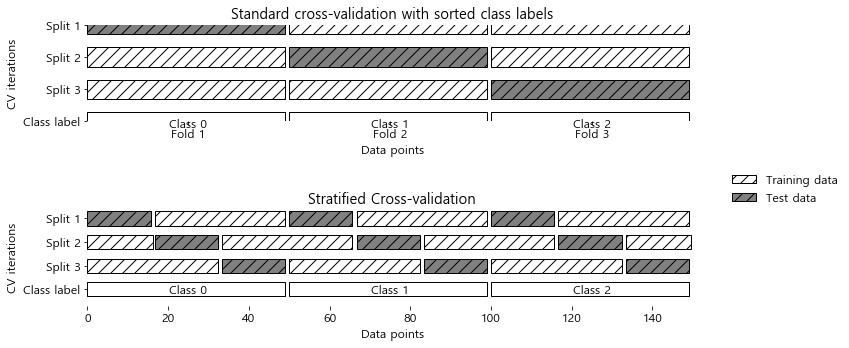

In [12]:
mglearn.plots.plot_stratified_cross_validation()

예를 들어 샘플의 90%가 클래스 A이고 10%가 클래스 B에 속한다면, 계층별 교차 검증은 각 폴드에 클래스 A 샘플이 90%, 클래스 B 샘플이 10%가 되도록 만든다. 

분류기의 일반화 성능을 측정할 때 k-겹 교차 검증보다 더 안정적인 계층별 k-겹 교차 검증을 사용하는 것이 좋다. 클래스 B에 속한 샘플이 10% 정도라면 기본 k-겹 교차 검증에서는 클래스 A 샘플만 가진 폴드가 생기기 쉽다. 이런 폴드를 테스트 세트로 사용하면 분류기의 전체 성능을 크게 왜곡하게 된다.

scikit-learn은 회귀에서 기본 k-겹 교차 검증을 사용한다. 회귀에서도 폴드가 서로 다른 타깃값을 포함하도록 만들 수 있지만, 대부분 사용자에게는 생소한 일이며 일반적으로 사용하는 방법은 아니다.

### 교차 검증 상세 옵션

앞서 cross_val_score를 사용할 때 cv 매개변수를 이용해 폴드의 개수를 조정해보았다. 그러나 scikit-learn에서는 cv 매개변수에 **교차 검증 분할기**(cross-validation splitter)를 전달함으로써 데이터를 분할할 때 더 세밀하게 제어할 수 있다. 대부분의 경우 회귀에서는 k-겹 교차 검증, 분류에서는 계층별 k-겹 교차 검증의 기본값이 잘 작동한다. 하지만 조금 다른 전략이 필요할 때가 있다. 예를 들면, 다른 사람의 결과를 재현하기 위해 분류 데이터셋에 기본 k-겹 교차 검증을 사용해야 할 때이다. 이렇게 하려면 먼저 model_selection 모듈에서 Kfold 분할기를 임포트하고 원하는 폴드 수를 넣어 객체를 생성해야한다.

In [13]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)

print("교차 검증 점수:\n", cross_val_score(logreg, iris.data, iris.target, cv=kf))

교차 검증 점수:
 [1.         0.93333333 0.43333333 0.96666667 0.43333333]


C:\Users\NT500R\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\NT500R\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\NT500R\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\NT500R\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\NT500R\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Defau

In [14]:
kf = KFold(n_splits=3)
print("교차 검증 점수:\n", cross_val_score(logreg, iris.data, iris.target, cv=kf))

교차 검증 점수:
 [0. 0. 0.]


C:\Users\NT500R\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\NT500R\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\NT500R\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


각 폴드는 iris 데이터셋의 클래스 중 하나에 대응하므로 아무것도 학습할 수가 없다. 계층별 폴드를 만드는 대신 이 문제를 해결하는 다른 방법은 데이터를 섞어서 샘플의 순서를 뒤죽박죽으로 만드는 것이다. 이렇게 하려면 KFold의 shuffle 매개변수를 True로 주면 된다. 데이터를 섞을 때 random_state를 고정해서 똑같은 작업을 재현할 수 있다. 그렇지 않으면 cross_val_score를 실행할 때마다 폴드가 바뀌어 매번 결과가 달라질 것이다. 데이터를 분할하기 전에 섞어주면 결과를 더 좋게 만든다.

In [15]:
kf = KFold(n_splits=3, shuffle=True, random_state=0)
print("교차 검증 점수:\n", cross_val_score(logreg, iris.data, iris.target, cv=kf))

교차 검증 점수:
 [0.9  0.96 0.96]


C:\Users\NT500R\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\NT500R\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\NT500R\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\NT500R\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\NT500R\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Defau

### LOOCV

또 다른 교차 검증 방법으로 **LOOCV**(Leave-One-Out Cross-Validation)도 자주 사용한다. LOOCV 교차 검증은 폴드 하나에 샘플 하나만 들어 있는 k-겹 교차 검증으로 생각할 수 있다. 각 반복에서 하나의 데이터 포인트를 선택해 테스트 세트로 사용한다. 특히 데이터셋이 클 때는 시간이 매우 오래 걸리지만, 작은 데이터셋에서는 이따금 더 좋은 결과를 만들어 낸다.

In [16]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
scores = cross_val_score(logreg, iris.data, iris.target, cv = loo)
print("교차 검증 분할 횟수: ", len(scores))
print("평균 정확도: {:.2f}".format(scores.mean()))

# 결과값 분할횟수 : 150, 평균 정확도 : 0.95

C:\Users\NT500R\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\NT500R\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\NT500R\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\NT500R\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\NT500R\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Defau

C:\Users\NT500R\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\NT500R\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\NT500R\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\NT500R\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\NT500R\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Defau

교차 검증 분할 횟수:  150
평균 정확도: 0.95


C:\Users\NT500R\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\NT500R\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\NT500R\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\NT500R\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\NT500R\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Defau

### 임의 분할 교차 검증

매우 유연한 또 하나의 교차 검증 전략은 **임의 분할 교차 검증**(shuffle-split cross-validation)이다. 임의 분할 교차 검증에서는 train_size만큼의 포인트로 훈련 세트를 만들고, test_size만큼의 (훈련 세트와 중첩되지 않은) 포인트로 테스트 세트를 만들도록 분할한다. 이 분할은 n_splits 횟수만큼 반복된다. 

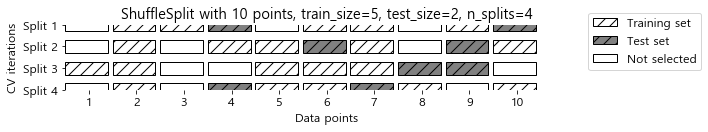

In [17]:
mglearn.plots.plot_shuffle_split()

위 그림은 샘플이 10개인 데이터셋을 5개 포인트의 훈련 세트, 2개 포인트의 테스트 세트로 4번 반복하여 나누는 것을 보여준다.

다음 코드는 데이터셋의 50%를 훈련, 나머지 50%를 테스트 세트로 10번 반복 분할하는 것이다.

In [18]:
from sklearn.model_selection import ShuffleSplit
shuffle_split = ShuffleSplit(test_size=.5, train_size=.5, n_splits=10)
scores = cross_val_score(logreg, iris.data, iris.target, cv=shuffle_split)
print("교차 검증 점수:\n", scores)

교차 검증 점수:
 [0.89333333 0.93333333 0.93333333 0.92       0.97333333 0.93333333
 0.98666667 0.89333333 0.90666667 0.96      ]


C:\Users\NT500R\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\NT500R\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\NT500R\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\NT500R\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\NT500R\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Defau

임의 분할 교차 검증은 반복 횟수를 훈련 세트나 테스트 세트의 크기와 독립적으로 조절해야 할 때 유용하다. 또한 train_size와 test_size의 합을 전체와 다르게 함으로써 전체 데이터의 일부만 사용할 수 있다. 이렇게 데이터를 부분 샘플링하는 방식은 대규모 데이터셋으로 작업할 때 도움이 된다.

한편 ShuffleSplit의 계층별 버전으로 분류 작업에 더 적합한 StratifiedShuffleSplit도 있다.

### 그룹별 교차 검증

데이터 안에 매우 연관된 그룹이 있을 때도 교차 검증을 널리 사용한다. 얼굴 사진에서 표정을 인식하는 시스템을 만들기 위해 100명의 사진을 모았다고 가정해보자. 한 사람을 찍은 여러 장의 사진이 각기 다른 표정을 담고 있다. 이 데이터셋에 없는 사람의 표정을 정확히 구분할 수 있는 분류기를 만드는 것이 목표이다. 이 분류기의 성능을 측정하기 위해 계층별 교차 검증을 사용할 수 있지만, 같은 사람의 사진이 훈련 세트와 테스트 세트에 모두 나타날 수 있다. 완전히 새로운 얼굴보다 훈련 세트에 있던 얼굴의 표정은 훨씬 쉽게 식별할 수 있을 것이다. 새 얼굴에 대한 일반화 성능을 더 정확하게 평가하려면 훈련 세트와 테스트 세트에 서로 다른 사람의 사진이 들어가도록 해야한다.

이를 위해 사진의 사람이 누구인지 기옥한 배열을 groups 매개변수로 전달받을 수 있는 GroupKfold를 사용할 수 있다. groups 배열은 훈련 세트와 테스트 세트를 만들 때 분리되지 않아야 할 그룹을 지정하는 것이며, 클래스 레이블과 혼동해서는 안된다.

데이터에 그룹이 있는 예로는 의료 애플리케이션이 일반적이다. 여기서는 같은 환자로부터 얻은 여러 샘플을 가지고 새로운 환자에서 일반화하는 것이 목적이다. 비슷하게 음성 인식에서도 데이터셋에 같은 사람의 목소리가 여러 개 녹음되어 있을 수 있으며, 관심 사항은 새로운 사람의 대화를 인식하는 것이다.

아래는 인위적으로 만든 데이터셋에 groups 배열로 그룹을 지정하는 예이다. 데이터셋은 12개의 포인트로 이뤄져 있고 groups는 각 데이터 포인트에 대해 각 포인트가 어떤 그룹(예를 들면 환자)에 속하는지를 나타낸다. 4개의 그룹을 나타내고 있으며 처음 3개의 샘플은 첫 번째 그룹, 다음 4개의 샘플은 두 번째 그룹을 나타내는 식이다.

In [19]:
from sklearn.model_selection import GroupKFold
# 인위적 데이터셋 생성
X, y = make_blobs(n_samples=12, random_state=0)
# 처음 세 개의 샘플은 같은 그룹에 속하고
# 다음은 네 개의 샘플이 같다.
groups = [0,0,0,1,1,1,1,2,2,3,3,3]
scores = cross_val_score(logreg, X, y, groups, cv=GroupKFold(n_splits=3))
print("교차 검증 점수:\n", scores)

교차 검증 점수:
 [0.75       0.8        0.66666667]


C:\Users\NT500R\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\NT500R\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\NT500R\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\NT500R\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\NT500R\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Defau

샘플 데이터를 그룹으로 정렬할 필요는 없다. 여기서는 예를 들기 위해서 정렬한 것뿐이다. 분할은 밑의 그림처럼 그룹 레ㅇ블을 기반으로 계산한다. 이 그림에서 볼 수 있듯이 각 분할에서 한 그룹 전체가 훈련 세트 아니면 테스트 세트에 있다.

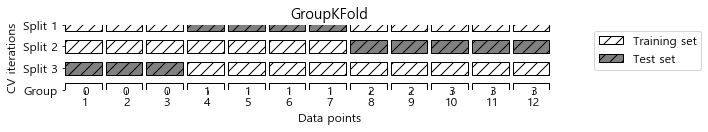

In [20]:
mglearn.plots.plot_group_kfold()

### 5.1.4 반복 교차 검증



데이터셋의 크기가 크지 않을 경우 안정된 검증 점수를 얻기 위해 교차 검증을 반복하여 여러 번 수행하는 경우가 많다. 이를 위해 scikit-learn 0.19 버전에서 RepeatedKFold와 RepeatedStratifiedKFold 분할기가 추가되었다. 이 클래스의 객체를 cross_val_score(또는 cross_validate) 함수의 cv 매개변수에 전달하여 교차 검증을 반복할 수 있다.

회귀에는 RefeatedKFold를 사용하고 RepeatedStratifiedKFold를 사용한다. RepeatedKFold는 KFold 클래스를 사용하여 훈련 폴드와 테스트 폴드를 분할한다. 이와 비슷하게 RepeatedStratifiedKFold는 StratifiedKFold 클래스를 사용한다. 분할 폴드 수 는 n_splits 매개변수로 설정하며 기본값은 5이다. 즉 기본적으로 5-겹 교차 검증을 수행한다. 반복 횟수는 n_repeats 매개변수로 설정하며 기본값은 10이다. 반복할 때마다 데이터를 다시 섞는다. 

In [22]:
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

iris = load_iris()
logreg = LogisticRegression()

In [23]:
from sklearn.model_selection import RepeatedStratifiedKFold

rskfold = RepeatedStratifiedKFold(random_state=42)
scores = cross_val_score(logreg, iris.data, iris.target, cv=rskfold)

print("교차 검증 점수:\n", scores)
print("교차 검증 평균 점수: {:.3f}".format(scores.mean()))

교차 검증 점수:
 [0.96666667 0.96666667 0.96666667 0.93333333 0.96666667 0.86666667
 0.96666667 0.96666667 0.93333333 0.96666667 1.         1.
 0.93333333 0.93333333 0.93333333 1.         0.96666667 0.96666667
 0.9        0.96666667 0.96666667 0.96666667 1.         0.9
 0.96666667 0.93333333 1.         0.96666667 0.96666667 0.93333333
 0.96666667 0.93333333 0.96666667 0.96666667 0.96666667 0.96666667
 0.93333333 0.93333333 0.96666667 1.         0.96666667 0.96666667
 0.86666667 1.         0.93333333 1.         0.96666667 1.
 0.93333333 0.9       ]
교차 검증 평균 점수: 0.957


C:\Users\NT500R\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\NT500R\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\NT500R\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\NT500R\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\NT500R\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Defau

반복 교차 검증으로 평균 점수 0.957을 얻었다. 반복 교차 검증을 위한 이 두 분할기는 다음 절에 설명할 GridSearchCV의 cv 매개변수에도 적용할 수 있다.